# Simulating Noise

For quantum computation below a threshold of qubits (perhaps a nice un-round number 53), 

Q: is it possible to tell the difference between results from:
+ a classical computer simulating quantum error 
+ a physical quantum computer

A: let's find out...


In [22]:
from qiskit import Aer, IBMQ, execute
from qiskit.providers.aer import noise
from qiskit.transpiler import CouplingMap
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.tools.monitor import job_monitor
from qiskit.tools.visualization import plot_histogram
from qiskit.visualization import plot_state_qsphere
from qiskit.visualization import plot_state_city

In [23]:
# Construct quantum circuit
qr = QuantumRegister(3, 'qr')
cr = ClassicalRegister(3, 'cr')
circ = QuantumCircuit(qr, cr)
circ.h(qr[0])
circ.cx(qr[0], qr[1])
circ.cx(qr[1], qr[2])
circ.measure(qr, cr)
qc = circ

In [24]:
# Select the QasmSimulator from the Aer provider
simulator = Aer.get_backend('qasm_simulator')

In [25]:
# Execute and get counts
result = execute(qc, simulator).result()
counts = result.get_counts(qc)

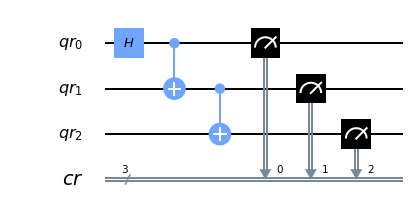

In [26]:
qc.draw(output='mpl')

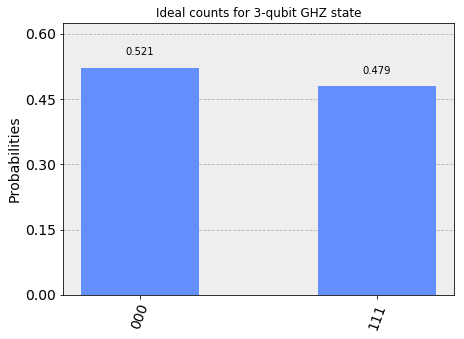

In [27]:
plot_histogram(counts, title='Ideal counts for 3-qubit GHZ state')

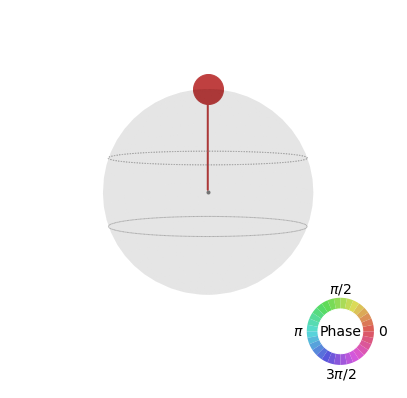

In [28]:
backend = Aer.get_backend('statevector_simulator')
job = execute(qc, backend).result()
statevector = job.get_statevector(qc)
plot_state_qsphere(statevector)

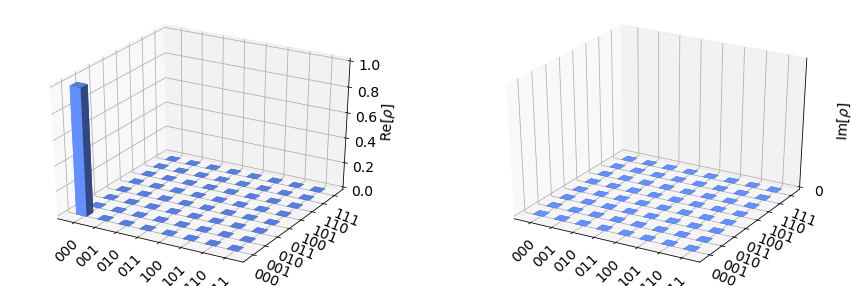

In [29]:
plot_state_city(statevector)

In [30]:
# List of gate times for ibmq_14_melbourne device
# Note that the None parameter for u1, u2, u3 is because gate
# times are the same for all qubits
# gate_times = [
#     ('u1', None, 0), ('u2', None, 100), ('u3', None, 200),
#     ('cx', [1, 0], 678), ('cx', [1, 2], 547), ('cx', [2, 3], 721),
#     ('cx', [4, 3], 733), ('cx', [4, 10], 721), ('cx', [5, 4], 800),
#     ('cx', [5, 6], 800), ('cx', [5, 9], 895), ('cx', [6, 8], 895),
#     ('cx', [7, 8], 640), ('cx', [9, 8], 895), ('cx', [9, 10], 800),
#     ('cx', [11, 10], 721), ('cx', [11, 3], 634), ('cx', [12, 2], 773),
#     ('cx', [13, 1], 2286), ('cx', [13, 12], 1504), ('cx', [], 800)
# ]

In [31]:
# Construct the noise model from backend properties
# and custom gate times
# noise_model = noise.device.basic_device_noise_model(properties, gate_times=gate_times)

noise_model = noise.NoiseModel(['h', 'cx'])
noise_model

NoiseModel: Ideal

In [32]:
from qiskit.providers.aer.noise.errors import depolarizing_error

In [33]:
print('noise_model before', noise_model.to_dict())

noise_model before {'errors': [], 'x90_gates': []}


In [34]:
# Adding some noise...
error2 = depolarizing_error(0.1, 2)
noise_model.add_all_qubit_quantum_error(error2, ['cx'])
after = noise_model.to_dict()

In [38]:
after = noise_model.to_dict()
print('noise_model after', after)
print('noise_model after', after['errors'][0]['probabilities'])


noise_model after {'errors': [{'type': 'qerror', 'operations': ['cx'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'x', 'qubits': [1]}], [{'name': 'x', 'qubits': [0]}, {'name': 'x', 'qubits': [1]}], [{'name': 'y', 'qubits': [0]}, {'name': 'x', 'qubits': [1]}], [{'name': 'z', 'qubits': [0]}, {'name': 'x', 'qubits': [1]}], [{'name': 'y', 'qubits': [1]}], [{'name': 'x', 'qubits': [0]}, {'name': 'y', 'qubits': [1]}], [{'name': 'y', 'qubits': [0]}, {'name': 'y', 'qubits': [1]}], [{'name': 'z', 'qubits': [0]}, {'name': 'y', 'qubits': [1]}], [{'name': 'z', 'qubits': [1]}], [{'name': 'x', 'qubits': [0]}, {'name': 'z', 'qubits': [1]}], [{'name': 'y', 'qubits': [0]}, {'name': 'z', 'qubits': [1]}], [{'name': 'z', 'qubits': [0]}, {'name': 'z', 'qubits': [1]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00625, 0.00625, 0.00625, 0.00625, 0.00625, 0.00625, 0.00625, 0.00625, 0.00625, 0.00625, 0.00625, 0.00625, 0.

In [39]:
# Get the basis gates for the noise model
basis_gates = noise_model.basis_gates
# Select the QasmSimulator from the Aer provider
simulator = Aer.get_backend('qasm_simulator')
#
# Execute noisy simulation and get counts
#
result_noise = execute(circ, simulator, 
                       noise_model=noise_model,
                       coupling_map=CouplingMap([[0,1], [0,2], [1,2]]),
                       basis_gates=basis_gates).result()
counts_noise = result_noise.get_counts(circ)



In [40]:
print(counts_noise)
print('noise_model after all', noise_model.to_dict())

{'000': 456, '001': 40, '011': 12, '010': 8, '101': 16, '111': 437, '100': 12, '110': 43}
noise_model after all {'errors': [{'type': 'qerror', 'operations': ['cx'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'x', 'qubits': [1]}], [{'name': 'x', 'qubits': [0]}, {'name': 'x', 'qubits': [1]}], [{'name': 'y', 'qubits': [0]}, {'name': 'x', 'qubits': [1]}], [{'name': 'z', 'qubits': [0]}, {'name': 'x', 'qubits': [1]}], [{'name': 'y', 'qubits': [1]}], [{'name': 'x', 'qubits': [0]}, {'name': 'y', 'qubits': [1]}], [{'name': 'y', 'qubits': [0]}, {'name': 'y', 'qubits': [1]}], [{'name': 'z', 'qubits': [0]}, {'name': 'y', 'qubits': [1]}], [{'name': 'z', 'qubits': [1]}], [{'name': 'x', 'qubits': [0]}, {'name': 'z', 'qubits': [1]}], [{'name': 'y', 'qubits': [0]}, {'name': 'z', 'qubits': [1]}], [{'name': 'z', 'qubits': [0]}, {'name': 'z', 'qubits': [1]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00625, 0.00625

## Simulator (without noise)
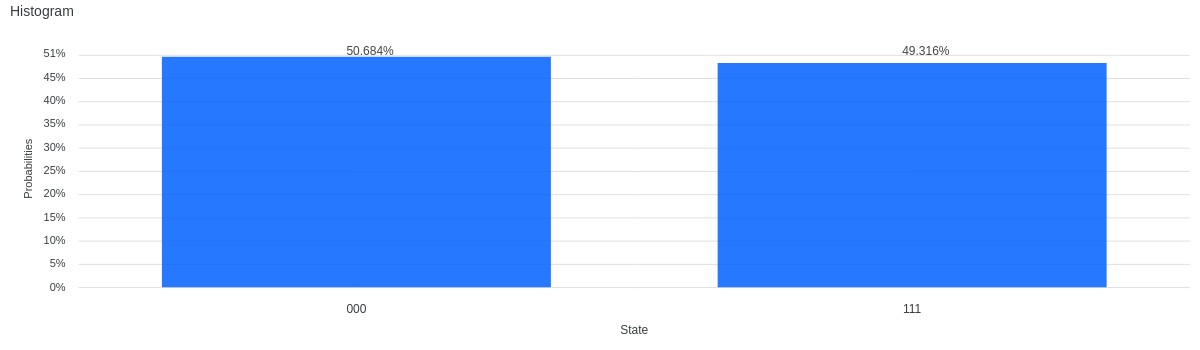
Here are the results from the 'quantum simulator'. As you can see the probability distribution of the results are only generated for the 000 and 111 gates.

 ## One of IBM's Quantum Computers
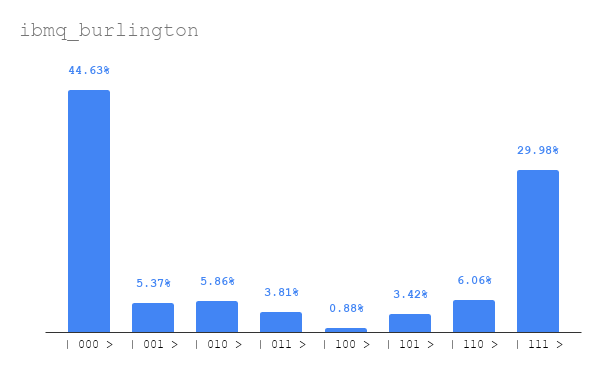
Here are the results from one of IBM's quantum computers available through their web interface.

#### Note: textual results shown on each bar are shown as percentages instead of as a probability from 0 to 1 as seen in our histogram below

Clearly more tests are to be done however, it is important to note that this is a proof of concept. The above shows that our local 'quantum simulator' is capable of inducing noise and returning a result that is not **theoretically** uniform. See below for our results...

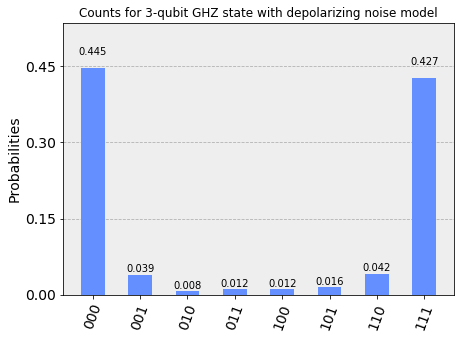

In [41]:
plot_histogram(counts_noise, title="Counts for 3-qubit GHZ state with depolarizing noise model")